###Importing Libraries

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 4.1 MB/s 
     |████████████████████████████████| 596 kB 57.4 MB/s 
     |████████████████████████████████| 6.6 MB 57.9 MB/s 
     |████████████████████████████████| 101 kB 7.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Convolution1D, MaxPooling1D, Flatten, Dense, concatenate, Dropout
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
import imblearn
from imblearn.over_sampling import SMOTE
import nltk 
from nltk.tokenize import RegexpTokenizer
import re
import transformers
from transformers import TFDistilBertModel, DistilBertConfig, DistilBertTokenizerFast

###Mounting Google Drive

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

###Dataset Loader

In [ ]:
def DataLoader(link, name_of_file):
  id = link.split("/")[-2]
  downloaded = drive.CreateFile({'id':id}) 
  downloaded.GetContentFile(name_of_file)
  dataframe = pd.read_csv(name_of_file)
  return dataframe


link1 = 'https://drive.google.com/file/d/1EfbAqgr7i9h4yFwEoU3igG34Gt48l6WT/view?usp=sharing'
link2 = 'https://drive.google.com/file/d/1Ya1OMWsz1yyXAaZheIck-roX0M9UWiqg/view?usp=sharing'
link6 = 'https://drive.google.com/file/d/1rLkJAwHkBAAkHMp2L1Y1AzuniIZdyB7x/view?usp=sharing'
name1 = 'long_parameters_list_structural.csv'
name2 = 'switch_statements_structural.csv'
name6 = 'semantic_final.csv'
df_lp = DataLoader(link1, name1)
df_ss = DataLoader(link2, name2)
df_semantic = DataLoader(link6,name6)

###Data Pre-Processing of Structural Dataset


In [ ]:
def PrePro(last_column, dataframe):
  dataframe.rename(columns = {last_column :'is_code_smell'}, inplace = True) #rename column
  dataframe['is_code_smell'] = dataframe["is_code_smell"].astype(int) #change boolean labels to int labels
  Y_part = dataframe.iloc[:,-1:]
  X_part = dataframe.iloc[:,:56]
  X_part = X_part.replace(to_replace =["?"], value = np.nan) #replace non existing values with null
  X_part = X_part.astype(float) #change datatype of features of X as float
  return X_part,Y_part

X_lp, Y_lp = PrePro('is_long_parameters_list',df_lp)
X_ss, Y_ss = PrePro('is_switch_statements',df_ss)

In [ ]:
def MeanforNaN(dataframe):   #function to fill null spaces with column mean 
  column_means = dataframe.mean()
  dataframe = dataframe.fillna(column_means)
  return dataframe

X_lp = MeanforNaN(X_lp)
X_ss = MeanforNaN(X_ss)

In [ ]:
def ConCat(df1,df2): #concatenate code smell datasets
  code_smells = [df1,df2]
  joint = pd.concat(code_smells)
  return joint

X_train = ConCat(X_lp,X_ss)
Y_train = ConCat(Y_lp,Y_ss)

In [ ]:
def Normalize(dataframe): #apply MinMax normalisation to fit the values between 0 to 1
  scaler = MinMaxScaler()
  model = scaler.fit(dataframe)
  scaled_data = model.transform(dataframe)
  return scaled_data

X_sample = Normalize(X_train)
Y_sample = Y_train.to_numpy(dtype='int64', copy='True')

###SVM SMOTE (Synthetic Minority Oversampling Technique) Algorithm for Imbalanced Datasets

In [ ]:
def Oversample(X_data,Y_data): # Using Smote obtain a 50-50 balanced dataset 

  sm = SMOTE(random_state = 2)
  X_train_res, Y_train_res = sm.fit_resample(X_data, Y_data.ravel())
  return X_train_res, Y_train_res

X_new, Y_new = Oversample(X_sample,Y_sample)

###Text Pre Processing

In [ ]:
def PrePro2(dataframe):
  X_part = dataframe.iloc[:,:-1]  
  return X_part

X_sem= PrePro2(df_semantic) #separate as X and Y columns

In [ ]:
def ToList(dataframe, string): #converts pandas.core.series.Series to list of lists
  new_column = dataframe[string].tolist()
  return list(map(lambda x:[x], new_column))

class_words = ToList(X_sem, 'class')
method_words = ToList(X_sem, 'method')

### Tokenization

In [ ]:
def TokenizeGroups(text): #tokenizes as per CamelCase RegEx and converts to lowercase
  tokenizer = RegexpTokenizer('[a-zA-Z](?:[a-z]+|[A-Z]*(?=[A-Z]|$))') # RegEx pattern for CamelCase 
  useful_text = tokenizer.tokenize(text) 
  useful_text = [x.lower() for x in useful_text]
  return useful_text

In [ ]:
def LoopOver(list): #loops over all the samples to tokenize all the strings in each word group
  for i in range(0,1146):
    list[i] = TokenizeGroups(list[i][0])
    i=i+1
  return list

class_words_sem = LoopOver(class_words)
method_words_sem = LoopOver(method_words)

In [ ]:
def WordList(list1,list2): #concatenate the words of each project, package, class and method
  final_list = []
  for i in range(0,1146):
    x = list1[i] + list2[i]
    final_list.append(x)
  res = [' '.join(ele) for ele in final_list]
  return res

word_groups = WordList(class_words_sem, method_words_sem)

###distilBERT pretrained + CNN

In [ ]:
params = {'MAX_LENGTH': 30,
          'EPOCHS': 50,
          'LEARNING_RATE': 5e-5,
          'FT_EPOCHS': 5,
          'OPTIMIZER': 'adam',
          'FT_LEARNING_RATE': 2e-5,
          'BATCH_SIZE': 64,
          'NUM_STEPS': len(X_train.index) // 64,
          'DISTILBERT_DROPOUT': 0.2,
          'DISTILBERT_ATT_DROPOUT': 0.2,
          'LAYER_DROPOUT': 0.2,
          'KERNEL_INITIALIZER': 'GlorotNormal',
          'BIAS_INITIALIZER': 'zeros',
          'POS_PROBA_THRESHOLD': 0.5,          
          'ADDED_LAYERS': 'Dense 256, Dense 32, Dropout 0.2',
          'LR_SCHEDULE': '5e-5 for 6 epochs, Fine-tune w/ adam for 6 epochs @2e-5',
          'FREEZING': 'All DistilBERT layers frozen for 6 epochs, then unfrozen for 6',
          'CALLBACKS': '[early_stopping monitoring val_loss w/ patience=0]',
          'RANDOM_STATE':42
          }

In [ ]:
def batch_encode(tokenizer, texts, batch_size=191, max_length=params['MAX_LENGTH']):
    input_ids = []
    attention_mask = []
    
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer.batch_encode_plus(batch,
                                             max_length=max_length,
                                             padding='longest',
                                             truncation=True,
                                             return_attention_mask=True,
                                             return_token_type_ids=False
                                             )
        input_ids.extend(inputs['input_ids'])
        attention_mask.extend(inputs['attention_mask'])
    
    
    return tf.convert_to_tensor(input_ids), tf.convert_to_tensor(attention_mask)

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
X_train_ids, X_train_attention = batch_encode(tokenizer, word_groups)

In [ ]:
distilBERT = TFDistilBertModel.from_pretrained('distilbert-base-uncased', output_hidden_states = True)

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_projector', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
for layer in distilBERT.layers:
    layer.trainable = False

In [ ]:
output = distilBERT([X_train_ids, X_train_attention])

In [ ]:
hidden_states = output[1]

In [ ]:
tfsentence = []
sentence_embeddings = []
sentence_emb_arr = []

In [ ]:
for i in range(1146):
  tfsentence.append(hidden_states[-2][i])

In [ ]:
for i in range(1146):
  samplei = tf.math.reduce_mean(tfsentence[i], axis=0)
  sentence_embeddings.append(samplei)

In [ ]:
for i in range(1146):
  storei = sentence_embeddings[i]
  storearr = storei.numpy()
  sentence_emb_arr.append(storearr)

In [ ]:
numarr = np.array(sentence_emb_arr)

In [ ]:
concat = np.concatenate((numarr, X_new), axis=1)

In [ ]:
# X_bert =concat .reshape(1146,824,1)

###Stratified K-Fold Cross Validation

In [ ]:
def StratiefKFoldCrossValidation(dataX,dataY): #split the dataset into train and test using k-5 fold cross validation
  skf = StratifiedKFold(n_splits=5, random_state = None, shuffle=True) 

  for train_index, test_index in skf.split(dataX , dataY):
        X_crosstrain, X_crosstest = dataX[train_index], dataX[test_index] 
        Y_crosstrain, Y_crosstest = dataY[train_index], dataY[test_index]
        return X_crosstrain,X_crosstest,Y_crosstrain,Y_crosstest

X_berttrain,X_berttest,Y_berttrain,Y_berttest = StratiefKFoldCrossValidation(concat, Y_new)

In [ ]:
from keras.models import Sequential

In [ ]:
model = Sequential()
model.add(Convolution1D(filters=32, kernel_size=3, activation='relu', input_shape=(824,1)))
model.add(Convolution1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution1D(filters=64, kernel_size=3, activation='relu'))
model.add(Convolution1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
# model.add(Dense(50, activation='relu'))
# model.add(Dense(25, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 822, 32)           128       
                                                                 
 conv1d_1 (Conv1D)           (None, 820, 64)           6208      
                                                                 
 dropout_19 (Dropout)        (None, 820, 64)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 818, 64)           12352     
                                                                 
 conv1d_3 (Conv1D)           (None, 816, 128)          24704     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 408, 128)         0         
 )                                                               
                                                        

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy', 'precision', 'recall', 'f1score'])

In [ ]:
history = model.fit(X_berttrain, Y_berttrain, batch_size=200, epochs=20, validation_data=(X_berttest,Y_berttest))

Epoch 1/20
5/5 [==============================] - 11s 147ms/step - loss: 0.8745 - accuracy: 0.5098 - val_loss: 0.6731 - val_accuracy: 0.6087
Epoch 2/20
5/5 [==============================] - 0s 46ms/step - loss: 0.6715 - accuracy: 0.5710 - val_loss: 0.6862 - val_accuracy: 0.5000
Epoch 3/20
5/5 [==============================] - 0s 46ms/step - loss: 0.6803 - accuracy: 0.5011 - val_loss: 0.6812 - val_accuracy: 0.5174
Epoch 4/20
5/5 [==============================] - 0s 46ms/step - loss: 0.6689 - accuracy: 0.5786 - val_loss: 0.6655 - val_accuracy: 0.7261
Epoch 5/20
5/5 [==============================] - 0s 46ms/step - loss: 0.6424 - accuracy: 0.7609 - val_loss: 0.6247 - val_accuracy: 0.7391
Epoch 6/20
5/5 [==============================] - 0s 46ms/step - loss: 0.5806 - accuracy: 0.7937 - val_loss: 0.5344 - val_accuracy: 0.7565
Epoch 7/20
5/5 [==============================] - 0s 46ms/step - loss: 0.4788 - accuracy: 0.8111 - val_loss: 0.4765 - val_accuracy: 0.7696
Epoch 8/20
5/5 [=========

In [ ]:
_, train_acc = model.evaluate(X_berttrain , Y_berttrain,verbose=0)
_, test_acc = model.evaluate(X_berttest, Y_berttest, verbose=0)

In [ ]:
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.910, Test: 0.848


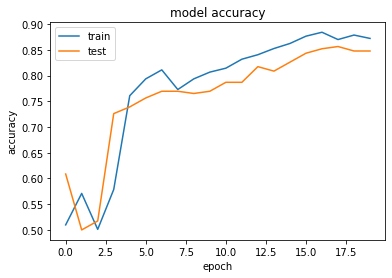

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

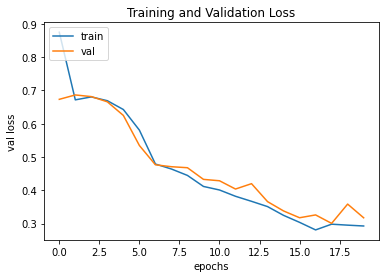

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Loss')
plt.ylabel('val loss')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()